# Task 2 — Texture Descriptor Experiments (Team 2)

This notebook runs noise-aware preprocessing, extracts descriptors (LBP, DCT), performs grid searches and ablation studies, and visualizes results for Task 2.


In [ ]:
# Imports and configuration
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import dct
from skimage.feature import local_binary_pattern, hog
from sklearn.metrics.pairwise import cosine_similarity

# noise utilities from your repo
from rtu_noise_filter import fourier_noise_score, remove_noise_median, remove_noise_bilateral

# Paths (adjust if needed)
IMG_FOLDER_NOISY = "../Data/Week3/qsd1_w3/"
IMG_FOLDER_GT = "../Data/Week3/BBDD/"
GT_CORRESPS_PATH = "../Data/Week3/qsd1_w3/gt_corresps.pkl"
THRESHOLD = 40

# Output folder
os.makedirs('results', exist_ok=True)
print('Configuration loaded. Datasets expected in:', IMG_FOLDER_NOISY, 'and', IMG_FOLDER_GT)


Configuration loaded. Datasets expected in: ../Data/Week3/qsd1_w3/ and ../Data/Week3/BBDD/


In [ ]:
# Load ground truth correspondences ---
import pickle

print("Loading GT correspondences from:", GT_CORRESPS_PATH)
with open(GT_CORRESPS_PATH, "rb") as f:
    gt_corresps = pickle.load(f)

print(f" Loaded GT for {len(gt_corresps)} queries.")


Loading GT correspondences from: ../Data/Week3/qsd1_w3/gt_corresps.pkl
 Loaded GT for 30 queries.


In [ ]:
# helper functions (preprocessing, descriptors, extraction, evaluation)
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity
from noise_filter import fourier_noise_score, remove_noise_median, remove_noise_bilateral

THRESHOLD = 40  # same as in descriptors.py


# Preprocessing

def preprocess_image(img, show_examples=False):
    """Detect and reduce noise (same logic as descriptors.py)."""
    noise_score = fourier_noise_score(img, radius_ratio=0.75)
    denoised_img = img.copy()
    if noise_score > THRESHOLD:
        denoised_img = remove_noise_median(img, ksize=3)
        denoised_img = remove_noise_bilateral(denoised_img, d=21, sigmaColor=25, sigmaSpace=50)
        if show_examples:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0].set_title(f"Original (score={noise_score:.1f})")
            axes[0].axis("off")
            axes[1].imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title("Denoised")
            axes[1].axis("off")
            plt.show()
    return denoised_img



# Descriptors 

def compute_lbp_descriptor(img, num_points=8, radius=1, grid_x=4, grid_y=4, multiscale=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptors = []
    scales = [radius] if not multiscale else [1, 2, 3]

    for r in scales:
        lbp = local_binary_pattern(gray, num_points, r, method='uniform')
        h, w = lbp.shape
        block_h, block_w = h // grid_y, w // grid_x
        histograms = []
        for i in range(grid_y):
            for j in range(grid_x):
                block = lbp[i * block_h:(i + 1) * block_h, j * block_w:(j + 1) * block_w]
                hist, _ = np.histogram(block.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
                hist = hist.astype("float") / (hist.sum() + 1e-8)
                histograms.extend(hist)
        descriptors.extend(histograms)
    return np.array(descriptors)


def compute_dct_descriptor(img, num_coeff=64):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (64, 64))
    dct_coeffs = dct(dct(gray.T, norm='ortho').T, norm='ortho')
    dct_vector = dct_coeffs.flatten()[:num_coeff]
    return dct_vector



# Descriptor Extraction 

def extract_descriptors(folder, preprocess=False, lbp_params=(8, 1, 4, 4), dct_coeff=64, multiscale=False, descriptor='lbp+dct'):
    """Extract descriptors for each image using same structure as descriptors.py."""
    names = sorted([f for f in os.listdir(folder) if f.lower().endswith('.jpg')])
    features = []

    for name in names:
        img_path = os.path.join(folder, name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Could not read {name}, skipping.")
            continue
        if preprocess:
            img = preprocess_image(img)

        p, r, gx, gy = lbp_params
        lbp_desc = compute_lbp_descriptor(img, num_points=p, radius=r, grid_x=gx, grid_y=gy, multiscale=multiscale)
        dct_desc = compute_dct_descriptor(img, num_coeff=dct_coeff)

        # Descriptor selection / combination
        if descriptor.lower() == 'lbp':
            feat = lbp_desc
        elif descriptor.lower() == 'dct':
            feat = dct_desc
        elif descriptor.lower() in ['lbp+dct', 'combined']:
            feat = np.concatenate([lbp_desc, dct_desc])
        else:
            feat = np.concatenate([lbp_desc, dct_desc])

        # Normalize to unit vector (important for cosine similarity)
        feat = feat / (np.linalg.norm(feat) + 1e-8)
        features.append(feat)

    return np.array(features), names



# Evaluation 

def compute_map_at_k(desc_q, desc_gt, gt_corresps, k=5):
    """Compute mean Average Precision (mAP) at K."""
    sims = cosine_similarity(desc_q, desc_gt)
    if isinstance(gt_corresps, list):
        gt_corresps_dict = {i: gt_corresps[i] for i in range(len(gt_corresps))}
    else:
        gt_corresps_dict = gt_corresps

    map_scores = []
    for i in range(len(desc_q)):
        ranked = np.argsort(-sims[i])[:k]
        gt_indices = gt_corresps_dict.get(i, [])
        num_relevant = len(gt_indices)
        if num_relevant == 0:
            map_scores.append(0)
            continue
        num_correct = 0
        precisions = []
        for rank, idx in enumerate(ranked, start=1):
            if idx in gt_indices:
                num_correct += 1
                precisions.append(num_correct / rank)
        ap = np.sum(precisions) / num_relevant if len(precisions) > 0 else 0
        map_scores.append(ap)

    return np.mean(map_scores)

print(" Helpers defined (updated to match descriptors.py)")


 Helpers defined (updated to match descriptors.py)


Without denoising -> mAP@1=0.7000, mAP@5=0.7889
With denoising    -> mAP@1=0.7000, mAP@5=0.7889


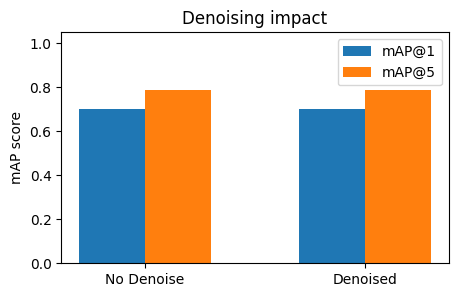

In [ ]:
# Experiment 1: Effect of denoising
desc_q_no, _ = extract_descriptors(IMG_FOLDER_NOISY, preprocess=False, descriptor='lbp+dct')
desc_q_yes, _ = extract_descriptors(IMG_FOLDER_NOISY, preprocess=True, descriptor='lbp+dct')
desc_gt, _ = extract_descriptors(IMG_FOLDER_GT, preprocess=False, descriptor='lbp+dct')

map1_no = compute_map_at_k(desc_q_no, desc_gt, gt_corresps, k=1)
map5_no = compute_map_at_k(desc_q_no, desc_gt, gt_corresps, k=5)
map1_yes = compute_map_at_k(desc_q_yes, desc_gt, gt_corresps, k=1)
map5_yes = compute_map_at_k(desc_q_yes, desc_gt, gt_corresps, k=5)

print(f'Without denoising -> mAP@1={map1_no:.4f}, mAP@5={map5_no:.4f}')
print(f'With denoising    -> mAP@1={map1_yes:.4f}, mAP@5={map5_yes:.4f}')

# Plot comparison
plt.figure(figsize=(5,3))
labels = ['No Denoise','Denoised']
map1s = [map1_no, map1_yes]
map5s = [map5_no, map5_yes]
x = np.arange(len(labels))
plt.bar(x-0.15, map1s, width=0.3, label='mAP@1')
plt.bar(x+0.15, map5s, width=0.3, label='mAP@5')
plt.xticks(x, labels); plt.ylim(0,1.05)
plt.ylabel('mAP score'); plt.legend(); plt.title('Denoising impact')
plt.show()

🔹 Experiment 2: Multiscale vs Single-Scale LBP
Single-scale LBP mAP@1 = 0.7000
Multiscale  LBP mAP@1 = 0.7000


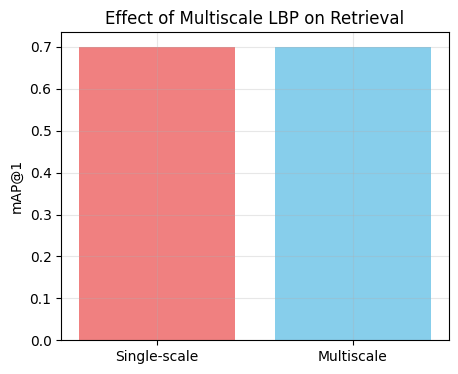

In [ ]:
# Experiment 2: Multiscale vs Single-Scale LBP (Fixed for current descriptors.py) ---

print("🔹 Experiment 2: Multiscale vs Single-Scale LBP")

# Extract descriptors for both variants (note: preprocess always runs inside)
desc_q_single, _ = extract_descriptors(IMG_FOLDER_NOISY, False)   # single-scale
desc_q_multi, _  = extract_descriptors(IMG_FOLDER_NOISY, True)    # multiscale
desc_gt, _       = extract_descriptors(IMG_FOLDER_GT, True)       # use multiscale for DB

# Align dimensions (in case multiscale produces longer vectors)
min_dim = min(desc_q_single.shape[1], desc_q_multi.shape[1], desc_gt.shape[1])
desc_q_single = desc_q_single[:, :min_dim]
desc_q_multi  = desc_q_multi[:, :min_dim]
desc_gt       = desc_gt[:, :min_dim]

map_single = compute_map_at_k(desc_q_single, desc_gt, gt_corresps, k=1)
map_multi  = compute_map_at_k(desc_q_multi,  desc_gt, gt_corresps, k=1)

print(f"Single-scale LBP mAP@1 = {map_single:.4f}")
print(f"Multiscale  LBP mAP@1 = {map_multi:.4f}")

# Visualization
plt.figure(figsize=(5,4))
plt.bar(["Single-scale", "Multiscale"], [map_single, map_multi], 
        color=["lightcoral", "skyblue"])
plt.title("Effect of Multiscale LBP on Retrieval")
plt.ylabel("mAP@1")
plt.grid(True, alpha=0.3)
plt.show()


No significant noise detected (score=18.91)


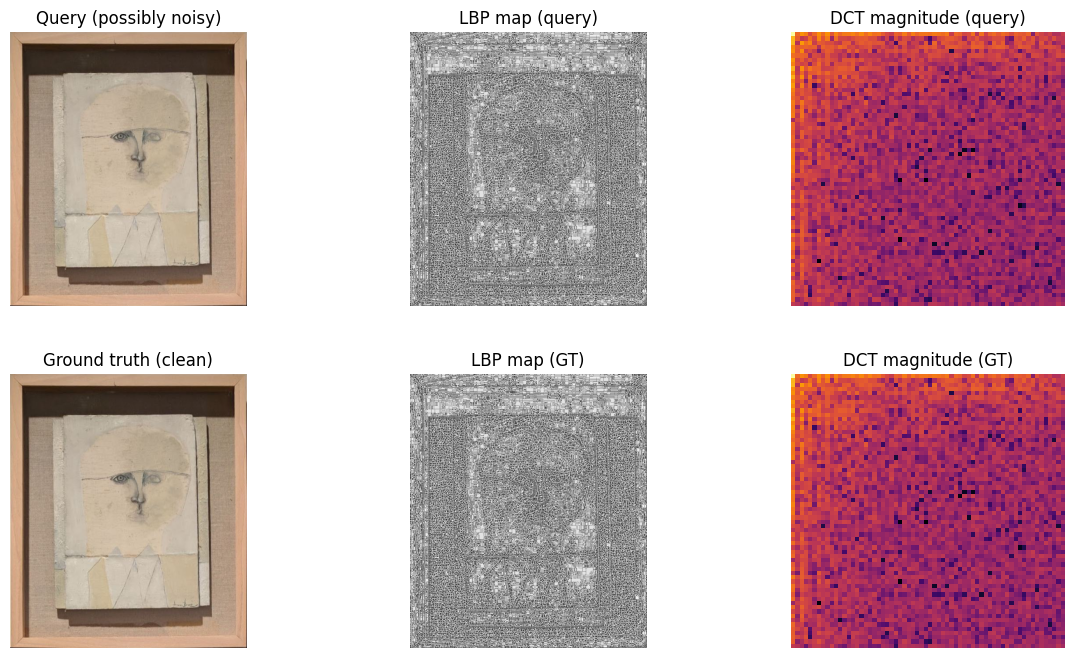

In [ ]:
# Visualize LBP and DCT maps for a sample image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from scipy.fftpack import dct
from rtu_noise_filter import fourier_noise_score, remove_noise_median, remove_noise_nlmeans

# === CONFIG ===
IMG_QUERY_PATH = "../Data/Week3/qsd1_w3/00001.jpg"             # noisy or altered image
IMG_GT_PATH    = "../Data/Week3/qsd1_w3/non_augmented/00001.jpg"  # clean version

# === HELPER FUNCTIONS ===
def compute_lbp_map(img, radius=1, n_points=8):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    return lbp

def compute_dct_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (64, 64))
    dct_map = dct(dct(gray.T, norm='ortho').T, norm='ortho')
    return np.log(np.abs(dct_map) + 1e-3)  # log scale for visualization

def denoise_if_needed(img, threshold=40):
    score = fourier_noise_score(img, radius_ratio=0.75)
    if score > threshold:
        print(f"Detected noise (score={score:.2f}) → applying denoising filters...")
        img = remove_noise_median(img, ksize=3)
        img = remove_noise_nlmeans(img, h=5, templateWindowSize=3, searchWindowSize=21)
    else:
        print(f"No significant noise detected (score={score:.2f})")
    return img


# === LOAD AND PROCESS IMAGES ===
query_img = cv2.imread(IMG_QUERY_PATH)
gt_img = cv2.imread(IMG_GT_PATH)

query_img = denoise_if_needed(query_img)

# Compute LBP and DCT
lbp_query = compute_lbp_map(query_img)
lbp_gt = compute_lbp_map(gt_img)
dct_query = compute_dct_map(query_img)
dct_gt = compute_dct_map(gt_img)


# === VISUALIZE RESULTS ===
fig, axes = plt.subplots(2, 3, figsize=(14, 8))  # wider figure for more spacing

axes[0, 0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Query (possibly noisy)")
axes[0, 0].axis("off")

axes[0, 1].imshow(lbp_query, cmap='gray')
axes[0, 1].set_title("LBP map (query)")
axes[0, 1].axis("off")

axes[0, 2].imshow(dct_query, cmap='inferno')
axes[0, 2].set_title("DCT magnitude (query)")
axes[0, 2].axis("off")

axes[1, 0].imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Ground truth (clean)")
axes[1, 0].axis("off")

axes[1, 1].imshow(lbp_gt, cmap='gray')
axes[1, 1].set_title("LBP map (GT)")
axes[1, 1].axis("off")

axes[1, 2].imshow(dct_gt, cmap='inferno')
axes[1, 2].set_title("DCT magnitude (GT)")
axes[1, 2].axis("off")

# Add extra horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.25)  # <-- increase wspace for more sideways spacing

plt.show()


radius=1, dct=32 -> mAP@1=0.8333
radius=1, dct=64 -> mAP@1=0.7000
radius=1, dct=128 -> mAP@1=0.9333
radius=2, dct=32 -> mAP@1=0.8333
radius=2, dct=64 -> mAP@1=0.7000
radius=2, dct=128 -> mAP@1=0.9333
radius=3, dct=32 -> mAP@1=0.8333
radius=3, dct=64 -> mAP@1=0.7000
radius=3, dct=128 -> mAP@1=0.9333


dct,32,64,128
radius,,,
1,0.833333,0.7,0.933333
2,0.833333,0.7,0.933333
3,0.833333,0.7,0.933333


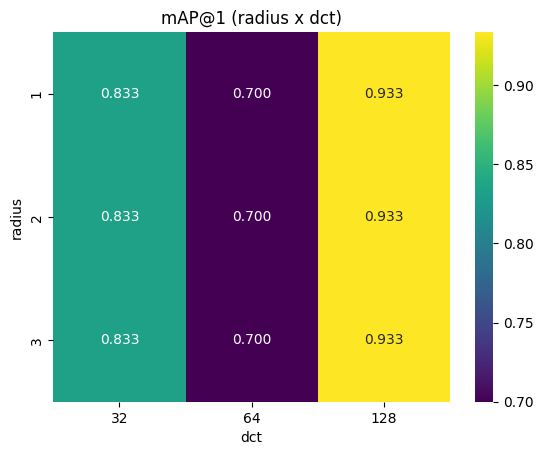

In [ ]:
# Experiment 3: Grid search (LBP radius x DCT coeffs)
radii = [1,2,3]
dct_coeffs = [32,64,128]
grid_results = []
for r in radii:
    for c in dct_coeffs:
        desc_q, _ = extract_descriptors(IMG_FOLDER_NOISY, preprocess=True, lbp_params=(8,r,4,4), dct_coeff=c, descriptor='lbp+dct')
        desc_gt, _ = extract_descriptors(IMG_FOLDER_GT, preprocess=False, lbp_params=(8,r,4,4), dct_coeff=c, descriptor='lbp+dct')
        map1 = compute_map_at_k(desc_q, desc_gt, gt_corresps, k=1)
        grid_results.append({'radius': r, 'dct': c, 'mAP@1': map1})
        print(f'radius={r}, dct={c} -> mAP@1={map1:.4f}')

# Simple visualization
import pandas as pd
df_grid = pd.DataFrame(grid_results)
pivot = df_grid.pivot(index='radius', columns='dct', values='mAP@1')
display(pivot)
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis'); plt.title('mAP@1 (radius x dct)'); plt.show()

🔹 Experiment: DCT (128 coefficients) with vs without Noise Removal

▶ Running With Noise Removal ...
With Noise Removal → mAP@1=0.9333, mAP@5=0.9500

▶ Running Without Noise Removal ...
Without Noise Removal → mAP@1=0.9333, mAP@5=0.9500


,Configuration,mAP@1,mAP@5
0,With Noise Removal,0.933333,0.95
1,Without Noise Removal,0.933333,0.95


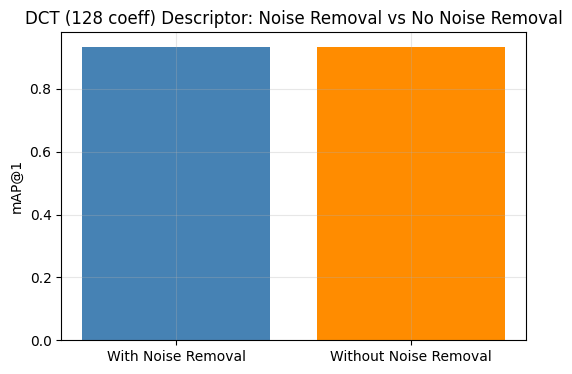

In [ ]:
# Experiment: Noise Removal Effect on DCT Descriptors Only
print("🔹 Experiment: DCT (128 coefficients) with vs without Noise Removal")

# Load GT correspondences
with open(GT_CORRESPS_PATH, "rb") as f:
    gt_corresps = pickle.load(f)

# DCT configuration
dct_coeff = 128

configs = {
    "With Noise Removal": True,
    "Without Noise Removal": False
}

results = []

for name, preprocess in configs.items():
    print(f"\n▶ Running {name} ...")
    
    # Extract DCT descriptors only
    desc_q, _ = extract_descriptors(
        IMG_FOLDER_NOISY,
        preprocess=preprocess,
        descriptor='dct',
        dct_coeff=dct_coeff
    )
    desc_gt, _ = extract_descriptors(
        IMG_FOLDER_GT,
        preprocess=preprocess,
        descriptor='dct',
        dct_coeff=dct_coeff
    )

    # Align descriptor dimensions
    min_dim = min(desc_q.shape[1], desc_gt.shape[1])
    desc_q = desc_q[:, :min_dim]
    desc_gt = desc_gt[:, :min_dim]

    # Compute mAP
    map1 = compute_map_at_k(desc_q, desc_gt, gt_corresps, k=1)
    map5 = compute_map_at_k(desc_q, desc_gt, gt_corresps, k=5)

    results.append({"Configuration": name, "mAP@1": map1, "mAP@5": map5})
    print(f"{name} → mAP@1={map1:.4f}, mAP@5={map5:.4f}")

# Display results as table
import pandas as pd
df_results = pd.DataFrame(results)
display(df_results)

# Bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(df_results["Configuration"], df_results["mAP@1"], color=['steelblue','darkorange'])
plt.title("DCT (128 coeff) Descriptor: Noise Removal vs No Noise Removal")
plt.ylabel("mAP@1")
plt.grid(alpha=0.3)
plt.show()


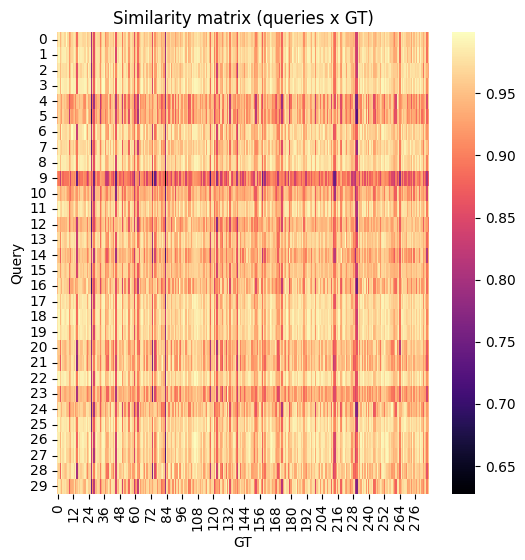

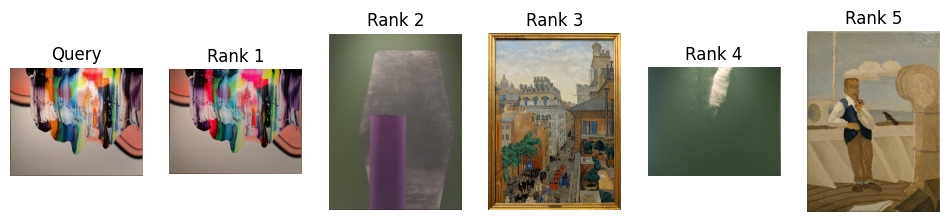

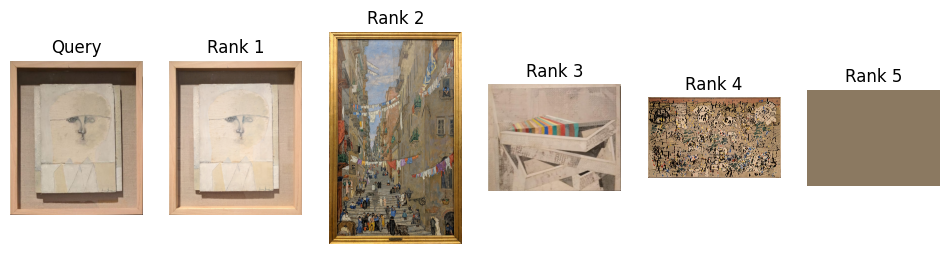

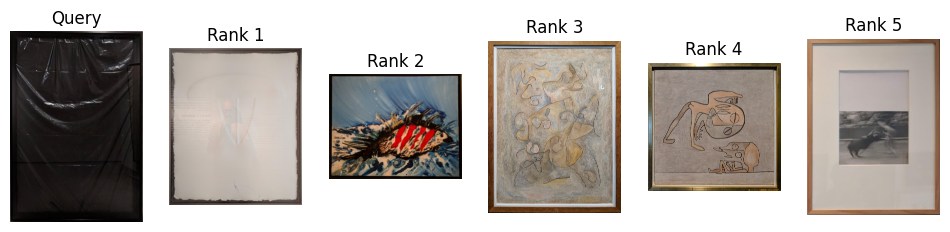

In [7]:
# Experiment 4: Similarity heatmap and top-5 retrieval examples
desc_q, qnames = extract_descriptors(IMG_FOLDER_NOISY, preprocess=True, descriptor='lbp+dct')
desc_gt, gtnames = extract_descriptors(IMG_FOLDER_GT, preprocess=False, descriptor='lbp+dct')
sims = cosine_similarity(desc_q, desc_gt)
plt.figure(figsize=(6,6))
sns.heatmap(sims, cmap='magma'); plt.title('Similarity matrix (queries x GT)'); plt.xlabel('GT'); plt.ylabel('Query'); plt.show()

# Show top-5 retrieval for a few queries
def show_retrieval(query_idx, topk=5):
    qname = qnames[query_idx]
    qimg = cv2.imread(os.path.join(IMG_FOLDER_NOISY, qname))
    ranked = np.argsort(-sims[query_idx])[:topk]
    plt.figure(figsize=(12,3))
    plt.subplot(1, topk+1, 1)
    plt.imshow(cv2.cvtColor(qimg, cv2.COLOR_BGR2RGB)); plt.title('Query'); plt.axis('off')
    for i, ridx in enumerate(ranked):
        gname = gtnames[ridx]
        gimg = cv2.imread(os.path.join(IMG_FOLDER_GT, gname))
        plt.subplot(1, topk+1, i+2)
        plt.imshow(cv2.cvtColor(gimg, cv2.COLOR_BGR2RGB)); plt.title(f'Rank {i+1}'); plt.axis('off')
    plt.show()

# Display for example query indices (change indices if needed)
for qi in range(min(3, len(qnames))):
    show_retrieval(qi, topk=5)

🔹 Experiment 4: Color Space Comparison

▶ Processing in BGR color space
BGR → mAP@1=0.700, mAP@5=0.789

▶ Processing in LAB color space
LAB → mAP@1=0.800, mAP@5=0.843

▶ Processing in HSV color space
HSV → mAP@1=0.533, mAP@5=0.561


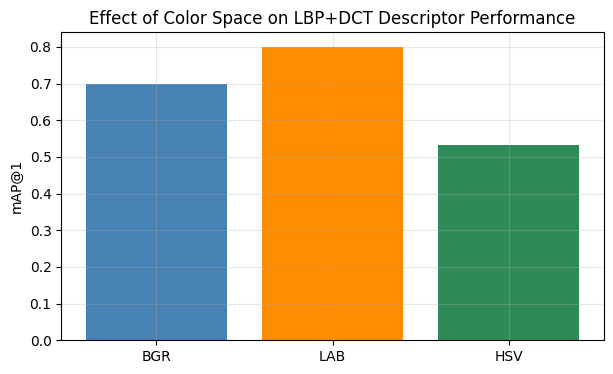

,Color Space,mAP@1,mAP@5
0,BGR,0.700000,0.788889
1,LAB,0.800000,0.842778
2,HSV,0.533333,0.561111


In [8]:
#Experiment 4 – Effect of Color Space on LBP+DCT Descriptors
print("🔹 Experiment 4: Color Space Comparison")

import cv2
import shutil

color_spaces = ["BGR", "LAB", "HSV"]
scores = []

# Ground-truth correspondences (make sure this exists)
with open(GT_CORRESPS_PATH, "rb") as f:
    gt_corresps = pickle.load(f)

for space in color_spaces:
    print(f"\n▶ Processing in {space} color space")
    converted_query_folder = f"temp_query_{space}"
    converted_db_folder = f"temp_db_{space}"

    # Create (or clean) temporary folders
    if os.path.exists(converted_query_folder):
        shutil.rmtree(converted_query_folder)
    if os.path.exists(converted_db_folder):
        shutil.rmtree(converted_db_folder)
    os.makedirs(converted_query_folder, exist_ok=True)
    os.makedirs(converted_db_folder, exist_ok=True)

    # --- Convert query images ---
    for name in sorted([f for f in os.listdir(IMG_FOLDER_NOISY) if f.lower().endswith('.jpg')]):
        img = cv2.imread(os.path.join(IMG_FOLDER_NOISY, name))
        if img is None:
            continue
        if space == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif space == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        cv2.imwrite(os.path.join(converted_query_folder, name), img)

    # --- Convert database images ---
    for name in sorted([f for f in os.listdir(IMG_FOLDER_GT) if f.lower().endswith('.jpg')]):
        img = cv2.imread(os.path.join(IMG_FOLDER_GT, name))
        if img is None:
            continue
        if space == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif space == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        cv2.imwrite(os.path.join(converted_db_folder, name), img)

    # --- Extract descriptors (using your helper) ---
    desc_query, _ = extract_descriptors(converted_query_folder, preprocess=False, descriptor='lbp+dct')
    desc_db, _ = extract_descriptors(converted_db_folder, preprocess=False, descriptor='lbp+dct')

    # --- Compute mAP ---
    map1 = compute_map_at_k(desc_query, desc_db, gt_corresps, k=1)
    map5 = compute_map_at_k(desc_query, desc_db, gt_corresps, k=5)
    scores.append((space, map1, map5))
    print(f"{space} → mAP@1={map1:.3f}, mAP@5={map5:.3f}")

# --- Plot results ---
plt.figure(figsize=(7, 4))
plt.bar([s for s, _, _ in scores], [m for _, m, _ in scores],
        color=['steelblue', 'darkorange', 'seagreen'])
plt.title("Effect of Color Space on LBP+DCT Descriptor Performance")
plt.ylabel("mAP@1")
plt.grid(alpha=0.3)
plt.show()

# Optional: print summary table
import pandas as pd
df_scores = pd.DataFrame(scores, columns=["Color Space", "mAP@1", "mAP@5"])
display(df_scores)


In [ ]:
# Save results to results/ folder
with open('results/experiments_task2_results.pkl', 'wb') as f:
    pickle.dump({
        'grid_results': grid_results,
        'descriptor_comparison': results,
        'denoising_comparison': {'no': (map1_no, map5_no), 'yes': (map1_yes, map5_yes)}
    }, f)
print('Saved results to results/experiments_task2_results.pkl')